#  Biodiversity Intactness Index change in Phoenix, AZ

Using Biodiversity Intactness Index (BII) from the Microsoft Planetary Computer STAC catalog and Phoenix Subdivision Shapefile to measure changes in biodiversity in Phoenix, Arizona

Author: Michelle Yiv

For further information and content about this analysis, view this [GitHub repository.](https://github.com/mmyiv/Changes-in-Biodiversity-Intactness-in-Arizona)


![Arizona Landscape. Source: azsustainabilityalliance.com](https://i0.wp.com/www.azsustainabilityalliance.com/wp-content/uploads/2019/05/Arizona_Biodiversity.jpeg?resize=1170%2C777&ssl=1)


#### Purpose


#### Datasets used

**1. California Fire Perimeter**

California fire perimeter was published by [CAL FIRE]((https://catalog.data.gov/dataset/california-fire-perimeters-all-b3436)) and contains information about fires in California. In addition to the geometries (perimeters) of each fire, there is information about the name, date, and acres burned.

**2. Landsat data** 

Landsat was published by [Microsoft Planetary Computer](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2) and contains both x,y coordinates and variables containing colors (R, G, B, NIR, SWIR) for plotting. This dataset contains the Santa Barbara location and surrounding areas. 


#### Analysis Highlights



#### References to datasets
Microsoft Planetary Computer. Biodiversity Intactness. [Dataset]. Microsoft. Retrieved December 5, 2024, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

Census Bureau, TIGER/Line Shapefiles. Census.Gov. 2024 County Subdivison Shapefile. [Dataset]. United States Census Bureau. Retrieved December 5, 2024, from https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html



AuthorLastName, AuthorFirstInitial OR Organization. (Year). Title of dataset (Version number) [Dataset]. Publisher. DOI or URL


## Set up

### Import packages

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import rioxarray as rioxr
import os
import contextily as cx
import matplotlib.pyplot as plt
from shapely import box

import pystac_client
import planetary_computer

from IPython.display import Image

### Read in data

In [2]:
# Read in shapefile for Arizona
fp = os.path.join('data','tl_2024_04_cousub.shp')
county = gpd.read_file(fp)

# Filter to Phoenix county subdivision
ph = county[county['NAME'] == 'Phoenix']

In [4]:
# Access data from MPC
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [16]:
# Set time range
time_range = "2017-01-01/2020-01-01"

# Set bbox according to course website
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# Catalog search
search = catalog.search(
    collections=["io-biodiversity"], 
    bbox=bbox, 
    datetime = time_range)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


### BII Analysis

#### 2017

In [19]:
# Get first item in the catalog search - 2017
item = items[3]

In [20]:
# Access raster data from item
bio_2017 = rioxr.open_rasterio(item.assets['data'].href)
bio_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [21]:
# Remove length 1 dimension (band)
bio_2017 = bio_2017.squeeze().drop_vars('band')

In [32]:
# Create GeoDataFrame from raster bounding box
bio_2017_bbox = gpd.GeoDataFrame(geometry=[box(*bio_2017.rio.bounds())], crs=bio_2017.rio.crs)

In [40]:
# Match CRSs and verify update
bio_2017_bbox = bio_2017_bbox.to_crs(ph.crs)
ph_match = ph.to_crs(bio_2017.rio.crs)

assert bio_2017.rio.crs == ph_match.crs

In [42]:
# Print raster no-data value
print('Original no-data value: ', bio_2017.rio.nodata)

# Update raster's no-data value
bio_2017 = bio_2017.rio.write_nodata(0)
print('Updated no-data value: ', bio_2017.rio.nodata)

Original no-data value:  0.0
Updated no-data value:  0.0


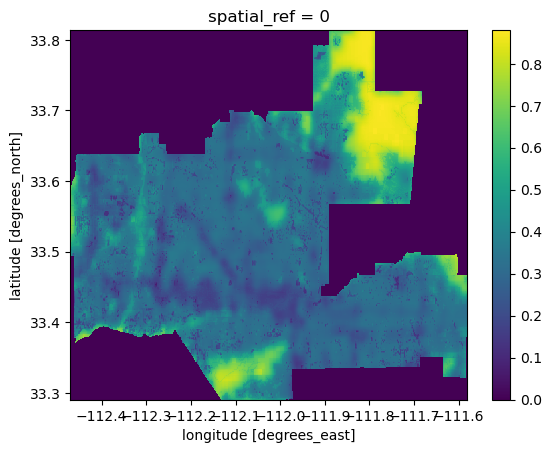

In [44]:
# Clip raster to match Phoenix 
bio_2017_clip = (bio_2017.rio.clip_box(*ph_match.total_bounds)
                         .rio.clip(ph_match.geometry))
# View
bio_2017_clip.plot()

In [ ]:
# Initial plot
ax = ph.plot(edgecolor="red", facecolor='none', figsize=(9, 9))
cx.add_basemap(ax, source = cx.providers.CartoDB.Positron, crs=ph.crs)